# **i. Introduction**

Name: Yocia Meiko Oke

Batch: RMT-036

Dataset: [ecommerce-web_analytics](https://console.cloud.google.com/bigquery?p=data-to-insights&d=ecommerce&t=web_analytics&page=table)

Dataset Description: This dataset contains information about visitors behaviour on a website, this also include where the traffic came from, the device visitors used, etc.([reference](https://github.com/FTDS-assignment-bay/p1-ftds036-rmt-g4-ymo98?tab=readme-ov-file#dataset-description)).

# **ii.Query SQL**

**Query dataset_1**
```
SELECT * EXCEPT(fullVisitorId)

FROM
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170531')
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
  ;
```

**Query dataset_2**
```
WITH all_visitor_stats AS (
  SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

SELECT * EXCEPT(unique_session_id) FROM (

  SELECT
    CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
    will_buy_on_return_visit,
    MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site,
    totals.pageviews,
    trafficSource.source,
    trafficSource.medium,
    channelGrouping,
    device.deviceCategory,

    IFNULL(geoNetwork.country, "Unknown") AS country

  FROM `data-to-insights.ecommerce.web_analytics`,
    UNNEST(hits) AS h

  JOIN all_visitor_stats USING(fullvisitorid)

  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170531'

  GROUP BY
    unique_session_id,
    will_buy_on_return_visit,
    bounces,
    time_on_site,
    totals.pageviews,
    trafficSource.source,
    trafficSource.medium,
    channelGrouping,
    device.deviceCategory,
    country
)
```

# **iii. Preliminary**

**Background**  

Our team is analyzing data from Google Analytics that contains information about the user behavior of an e-commerce website. 

We will analyze and create a Machine Learning model to predict whether a new user is likely to make a purchase in the future or not. 

The prediction results can later help the marketing team to provide promotions and product offers, especially for users who have the potential to make purchases ([reference](https://github.com/FTDS-assignment-bay/p1-ftds036-rmt-g5-ymo98#:~:text=Tim%20Anda%20sedang,berpotensi%20melakukan%20pembelian)). 

**Problem Statement**  

The goal is to increase sales by 25% by the end of 2024 by improving the ui/ux on website that can lead to conversions. Improving the customer journey on the site can also help increasing the collaboration with other business such as paid ads, etc.

**Objective**

To develop a predictive model that can predict whether a vistor will make a purchase by considering the visitors behavior on the site.

**Problem Breakdown**

1. Do bounces, time_on_site, and pageviews have a high enough influence to predict the will_buy_on_return_visit target?

2. What type of device is most commonly used by users in the Canada region who are likely to make a purchase when revisiting the website?

# **iv. Import Libraries**

First we will import all libraries and modules that we are going to use in this project.

In [212]:
# Import libraries
import pandas as pd # for data manipulation & analysis
import numpy as np # for numerical computations
import matplotlib.pyplot as plt # for visualizations
import seaborn as sns # for advanced visualizations
from scipy import stats # for relation analysis (chi-squared)
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split # to split the dataset to train and test
from scipy.stats import kendalltau # analysis

# Preprocessing
from sklearn.impute import SimpleImputer # to impute missing values
from sklearn.preprocessing import MinMaxScaler # numerical feature scaler
from sklearn.preprocessing import OneHotEncoder # categorical feature encoder
from imblearn.over_sampling import SMOTE # data imbalanced
from feature_engine.outliers import Winsorizer # handling outliers

# Model
from sklearn.linear_model import LogisticRegression # model
from sklearn.compose import ColumnTransformer # Pipeline
from imblearn.pipeline import Pipeline # Pipeline
from sklearn.model_selection import GridSearchCV # hyper parameter tuning

# Evaluation
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Model Inference
import pickle # save model
import json # save cols


# **v. Data Loading**

In this section, we will load the data for further data exploration and modelling.

We have 2 dataset that actually can predict the same target `will_buy_on_return_visit`. 

First we will analyze `dataset_1` and then make a model, and if the performance is not good, that we will do the same for `dataset_2` to see if it would have a better performance.

**dataset_1**

In [213]:
# Load dataset_1
df_1_ori = pd.read_csv("dataset_1.csv")

# Duplicate dataset_1
df_1 = df_1_ori.copy()

# Show dataset_1
df_1

,bounces,time_on_site,will_buy_on_return_visit
0,0,733,0
1,1,0,0
2,0,45,0
3,0,951,0
4,0,389,0
...,...,...,...
623996,0,49,0
623997,0,165,0
623998,0,54,0
623999,0,24,0


In [214]:
# Check dataset_1 using .info()
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624001 entries, 0 to 624000
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   bounces                   624001 non-null  int64
 1   time_on_site              624001 non-null  int64
 2   will_buy_on_return_visit  624001 non-null  int64
dtypes: int64(3)
memory usage: 14.3 MB


There are 3 columns of `int64` type:
- `bounces`: The number of visitors who leave the website immediately without taking any action
- `time_on_site`: The length of time visitors spend on the website
- `will_buy_on_return_visit`: Indicates whether the visitor will make a purchase when revisiting the website (1 = Yes, 0 = No)

**Check duplicates in dataset_1**

Now, we will check if the dataset has any duplicates, if it does, we will drop all the duplicated data since it doesn't hold any insightful values as they are all redudant.

In [215]:
# Check duplicates
df_1.duplicated().sum()

618597

In [216]:
# Drop duplicates
df_1.drop_duplicates(inplace=True)

In [217]:
# Re-check after dropping duplicates
df_1.duplicated().sum()

0

In [218]:
# Re-check dataset_1
df_1

,bounces,time_on_site,will_buy_on_return_visit
0,0,733,0
1,1,0,0
2,0,45,0
3,0,951,0
4,0,389,0
...,...,...,...
571266,0,3772,0
571267,0,4219,0
571273,0,6427,0
606105,0,1782,0


**The summary of dataset_1**:
- There are 3 integer columns
- The final shape after dropping the duplicated rows are: 5404 rows × 3 columns

- Numerical column = ['time_on_site']
- Categorical column= ['bounces']
- Our target = ['will_buy_on_return_visit']

**dataset_2**

In [219]:
# Load dataset_2
df_2_ori = pd.read_csv("dataset_2.csv")

# Duplicate dataset_2
df_2 = df_2_ori.copy()

# Show dataset_2
df_2

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,54,5.0,(direct),(none),Direct,desktop,Argentina
1,0,0,0,167,5.0,(direct),(none),Direct,mobile,India
2,0,0,0,184,5.0,google,organic,Organic Search,desktop,Ireland
3,0,0,0,141,5.0,google,organic,Organic Search,desktop,Belarus
4,0,0,0,715,5.0,google,organic,Organic Search,desktop,Israel
...,...,...,...,...,...,...,...,...,...,...
623935,0,0,0,41,3.0,plus.google.com,referral,Social,desktop,United States
623936,0,0,0,27,3.0,t.co,referral,Social,mobile,United States
623937,0,0,0,50,3.0,m.facebook.com,referral,Social,mobile,United States
623938,0,0,0,188,3.0,youtube.com,referral,Social,desktop,India


In [220]:
# Check dataset_2 using .info()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623940 entries, 0 to 623939
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   will_buy_on_return_visit   623940 non-null  int64  
 1   latest_ecommerce_progress  623940 non-null  int64  
 2   bounces                    623940 non-null  int64  
 3   time_on_site               623940 non-null  int64  
 4   pageviews                  623926 non-null  float64
 5   source                     623940 non-null  object 
 6   medium                     623940 non-null  object 
 7   channelGrouping            623940 non-null  object 
 8   deviceCategory             623940 non-null  object 
 9   country                    623940 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 47.6+ MB


There are 4 columns of `int64` type:
- `bounces`: Indicates whether the visitor leaves the website immediately without taking any action (1 = Yes, 0 = No)
- `time_on_site`: The length of time visitors spend on the website
- `will_buy_on_return_visit`: Indicates whether the visitor will make a purchase when revisiting the website (1 = Yes, 0 = No)
- `latest_ecommerce_progress`: the latest action that visitors did, the number ranges from 0 to 8: 
    - Click through of product lists = 1
    - Product detail views = 2
    - Add product(s) to cart = 3
    - Remove product(s) from cart = 4
    - Check out = 5
    - Completed purchase = 6
    - Refund of purchase = 7
    - Checkout options = 8
    - Unknown = 0

1 columns of `float64` type:
- `pageviews`: The number of pages visitors viewed

5 columns of `object` type:
- `source`: The source of the traffic source (the search engine, the referring hostname, or a value of the utm_source URL parameter)
- `medium`: The medium of the traffic source. ("organic", "cpc", "referral", or the value of the utm_medium URL parameter)
- `channelGrouping`: The Default Channel Group associated with an end user's session for this View.
- `deviceCategory`: The type of device (Mobile, Tablet, Desktop).
- `country`: The country from which sessions originated, based on IP address.

**Check duplicates in dataset_2**

We will also check if dataset_2 has any duplicates, if it does, we will drop all the duplicated data as well.

In [221]:
# Check duplicates
df_2.duplicated().sum()

438629

In [222]:
# Drop duplicates
df_2.drop_duplicates(inplace=True)

In [223]:
# Re-check duplicates
df_2.duplicated().sum()

0

In [224]:
# Re-check dataset_2
df_2

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,54,5.0,(direct),(none),Direct,desktop,Argentina
1,0,0,0,167,5.0,(direct),(none),Direct,mobile,India
2,0,0,0,184,5.0,google,organic,Organic Search,desktop,Ireland
3,0,0,0,141,5.0,google,organic,Organic Search,desktop,Belarus
4,0,0,0,715,5.0,google,organic,Organic Search,desktop,Israel
...,...,...,...,...,...,...,...,...,...,...
623932,0,0,0,103,3.0,m.facebook.com,referral,Social,mobile,France
623934,0,0,0,49,3.0,youtube.com,referral,Social,desktop,Denmark
623935,0,0,0,41,3.0,plus.google.com,referral,Social,desktop,United States
623936,0,0,0,27,3.0,t.co,referral,Social,mobile,United States


**The final summary of dataset_2**:
- There are 4 integer columns, 1 float, and 5 object
- The final shape after dropping the duplicated rows are: 185311 rows × 10 columns

- Numerical column = ['time_on_site', 'pageviews']
- Categorical nominal = ['bounces', 'source', 'medium', 'channelGrouping', 'deviceCategory', 'country']
- Categorical ordinal = ['latest_ecommerce_progress']
- Our target = ['will_buy_on_return_visit']

# **vi. Exploratory Data Analysis (EDA)**

Here, we will do exploratory data analysis to understand the data better, what can we get from the data, and lastly to see if we need to do extra step to extract more information in the Feature Engineering step.

## **dataset_1 EDA**

In [225]:
# Check unique values of numerical columns to decide what visualization to use for each column

num_wide_1 = [] # for numerical columns with wide range
num_small_1 = [] # for numerical columns with small range

for col in df_1.columns:
    if df_1[col].dtype != 'object':
        unique = df_1[col].value_counts().count()
        print(f"Unique value counts of '{col}': {unique}")
        if unique > 10:
            num_wide_1.append(col)
        else:
            num_small_1.append(col)

print(f'Wide numerical column: {num_wide_1}')
print(f'Small numerical column: {num_small_1}')

Unique value counts of 'bounces': 2
Unique value counts of 'time_on_site': 3619
Unique value counts of 'will_buy_on_return_visit': 2
Wide numerical column: ['time_on_site']
Small numerical column: ['bounces', 'will_buy_on_return_visit']


**Visualization for wide numerical column**

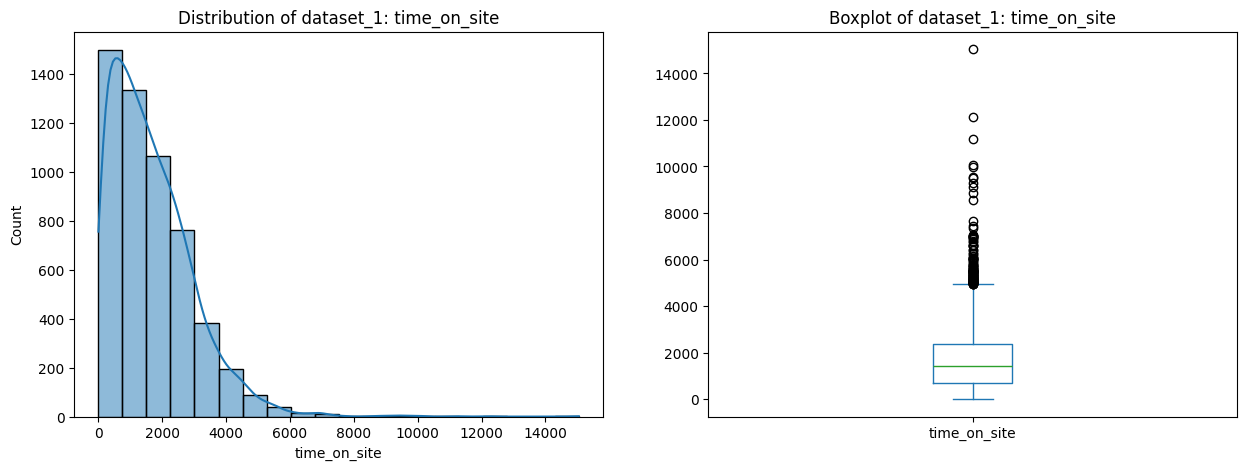

In [226]:
# Create canvas
plt.figure(figsize=(15,5))

# Plot histogram for the column
plt.subplot(1,2,1)
sns.histplot(df_1.time_on_site, kde=True,bins=20)
plt.title(f'Distribution of dataset_1: time_on_site')
plt.xlabel('time_on_site')

# Plot boxplot for the column
plt.subplot(1,2,2)
df_1.time_on_site.plot(kind='box')
plt.title(f'Boxplot of dataset_1: time_on_site')

# Show
plt.show()

**Insights**

- `time_on_site` has right-skewed distribution
- `time_on_site` has outliers, we will need to handle the outliers depending on further analysis (percentage of the outliers)

**Visualization for small numerical column**

In [227]:
# Small range numerical column
for col in num_small_1:
    unique_val = df_1[col].value_counts()
    print(f"Unique value of: {unique_val}")

Unique value of: bounces
0    5401
1       3
Name: count, dtype: int64
Unique value of: will_buy_on_return_visit
0    3519
1    1885
Name: count, dtype: int64


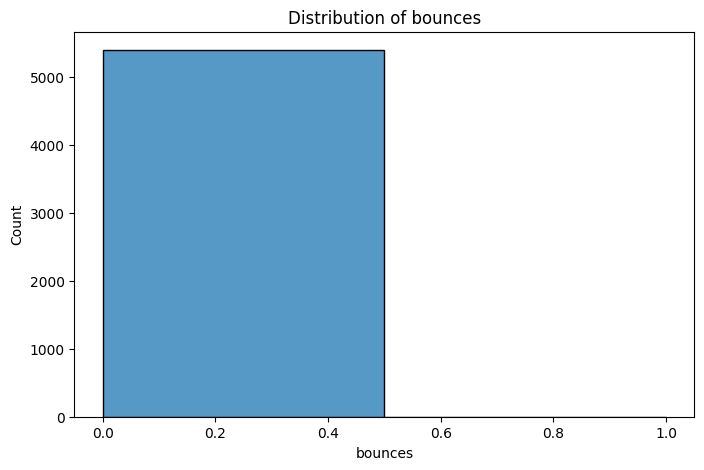

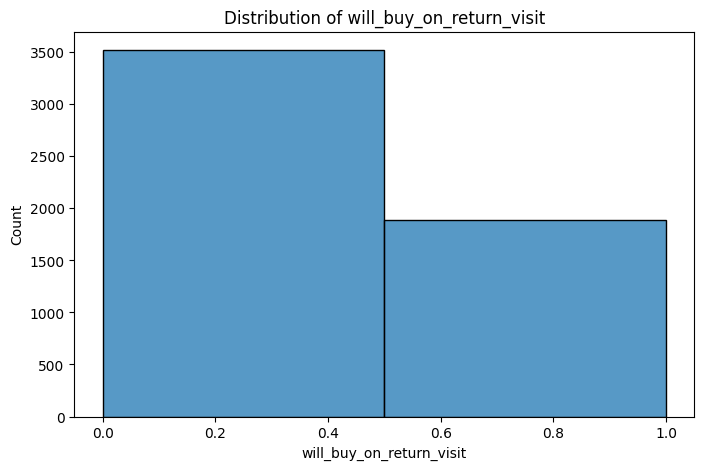

In [228]:
# Small range numerical column
for col in num_small_1:

    # Create a canvas
    plt.figure(figsize=(8,5))

    # Plot histogram for the column
    sns.histplot(df_1[col], bins=df_1[col].nunique())
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    
    # Show
    plt.show()

**Insights**

- `bounces` is imbalanced, as the majority of the value is 0 (5401 rows), an the rest is 1 (3 rows)
- `will_buy_on_return_visit` is also imbalanced, however we will not balance the data for dataset_1, since it seems that the ratio is roughly 60:40 (0 to 1)

**Correlation Matrix for dataset_1**

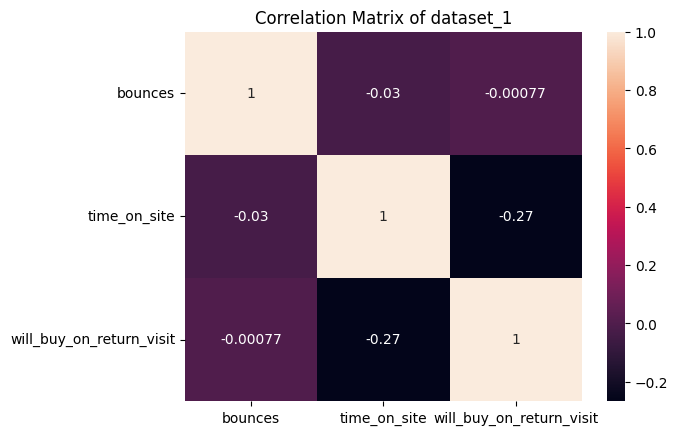

In [229]:
# Correlation matrix
corr_matrix = df_1[['bounces', 'time_on_site', 'will_buy_on_return_visit']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix of dataset_1")
plt.show()

**Insights**

`time_on_site` has a stronger correlation with the target feature compared to `bounces`, the gap is quite big.

However, we will not drop `bounces` as the number could be caused by the imbalanced data.

## **dataset_2 EDA**

In [230]:
# Check unique values of object columns
for col in df_2.columns:
    if df_2[col].dtype == 'object':
        unique = df_2[col].value_counts().count()
        print(f"Unique value counts of '{col}': {unique}")

Unique value counts of 'source': 294
Unique value counts of 'medium': 7
Unique value counts of 'channelGrouping': 8
Unique value counts of 'deviceCategory': 3
Unique value counts of 'country': 218


In [231]:
# Check unique values of numerical columns

numerical_columns = [] 
encoded_columns = []

for col in df_2.columns:
    if df_2[col].dtype != 'object':
        unique = df_2[col].value_counts().count()
        print(f"Unique value counts of '{col}': {unique}")
        if unique > 10:
            numerical_columns.append(col)
        else:
            encoded_columns.append(col)

Unique value counts of 'will_buy_on_return_visit': 2
Unique value counts of 'latest_ecommerce_progress': 7
Unique value counts of 'bounces': 2
Unique value counts of 'time_on_site': 3619
Unique value counts of 'pageviews': 180


In [232]:
print(f'Numerical columns: {numerical_columns}')
print(f'Encoded columns: {encoded_columns}')

Numerical columns: ['time_on_site', 'pageviews']
Encoded columns: ['will_buy_on_return_visit', 'latest_ecommerce_progress', 'bounces']


Based on the count of the unique value of each columnm, we will categorize the data into these categories, and then make a visualization loop for each category.

- Numerical Columns: ['time_on_site', 'pageviews']
- Encoded Columns: ['will_buy_on_return_visit', 'latest_ecommerce_progress', 'bounces']

**Numerical columns visualizations**

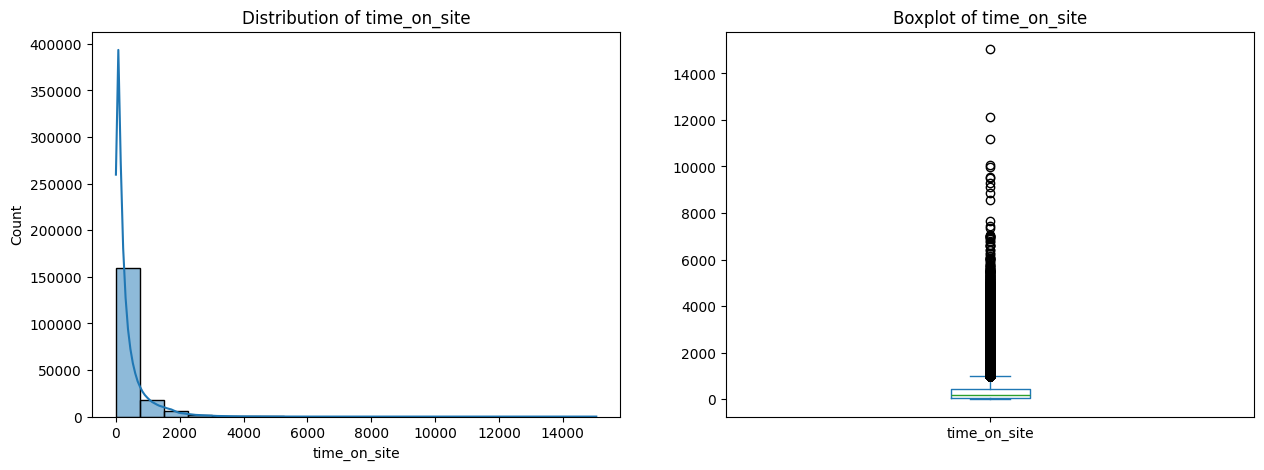

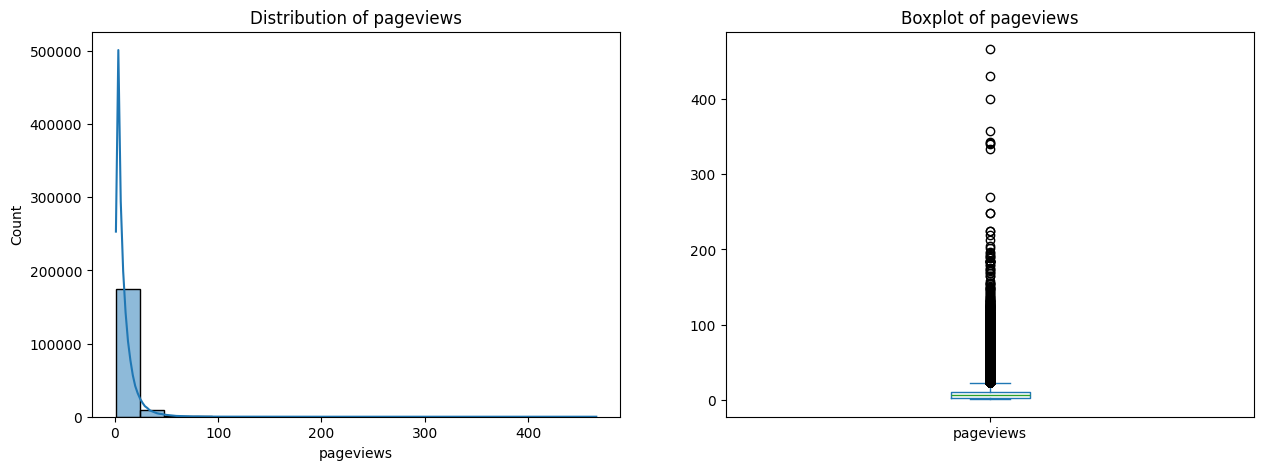

In [233]:
# Wide range numerical column
for col in numerical_columns:
    # Create canvas
    plt.figure(figsize=(15,5))

    # Plot histogram for the column
    plt.subplot(1,2,1)
    sns.histplot(df_2[col], kde=True,bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')

    # Plot boxplot for the column
    plt.subplot(1,2,2)
    df_2[col].plot(kind='box')
    plt.title(f'Boxplot of {col}')
        
    # Show
    plt.show()

**Insights**

From the visualizations, we can see that:  
- Right-skewed columns: `time_on_site`, `pageviews`
- All has outliers, we will be handling them with Winsorizer with the proper parameters for right-skewed distributions.

**Encoded columns visualization**

Here we will create a visualization for each column with Histogram (to see the distribution of the data)

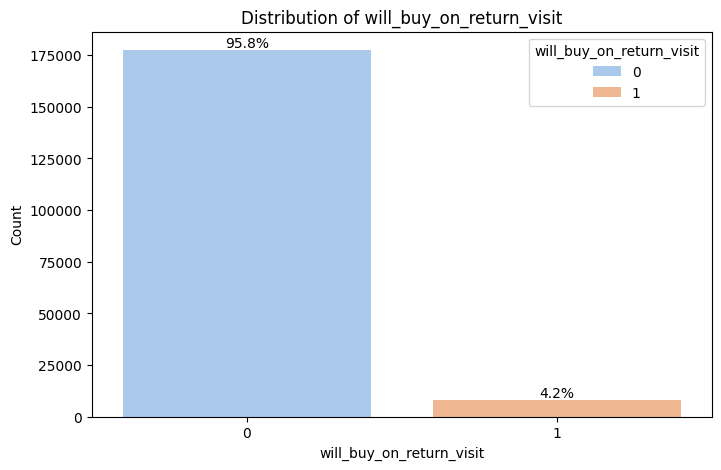

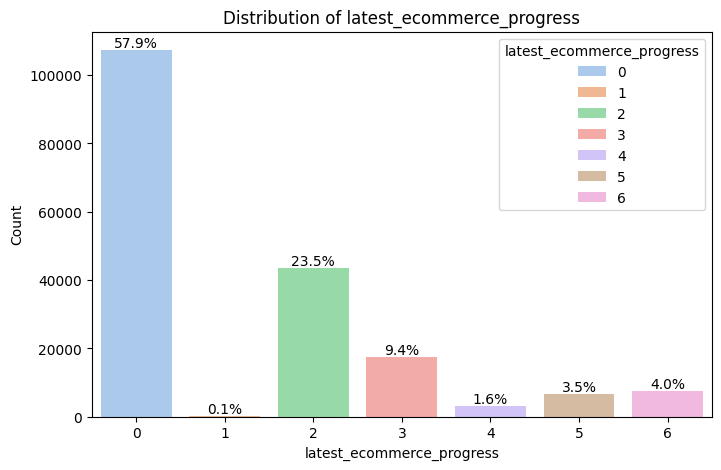

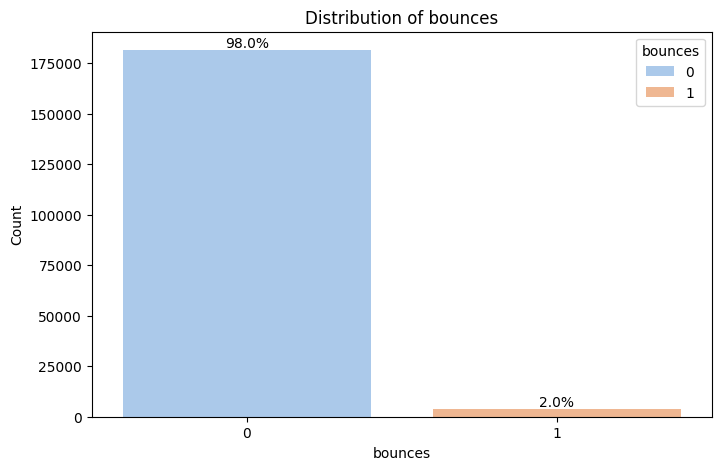

In [234]:
# Encoded columns visualizations
for col in encoded_columns:

    # Create a canvas
    plt.figure(figsize=(8,5))

    # Plot
    ax = sns.countplot(x=df_2[col], palette='pastel', hue = df_2[col])
    
    # Percentages
    total = len(df_2[col])
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.1f}%'  # Calculate percentage
        if height > 0:
            ax.annotate(percentage, 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points')
            
    # Title and labels
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Count')
    
    # Show
    plt.show()


**Insights**

From the visualizations, we can see that:  
- The target `will_buy_on_return_visit` is very imbalanced with the percentage of value `0` **95.8%**, hence we will need to do data balancing (with SMOTE)
- `latest_ecommerce_progress`: the visualization indicated that the latest action visitors did were mostly **0 (Unknown)**, however second highest latest step visitors did was **2 (viewing product details)**
- `bounces`: the visualization indicates that most people stay the site at least until they make an action

**Categorical columns**

Here we will create 2 visualization for each column:

- Countplot > to see the distribution of the data
- Pie chart > to see the percentage of groups in a column

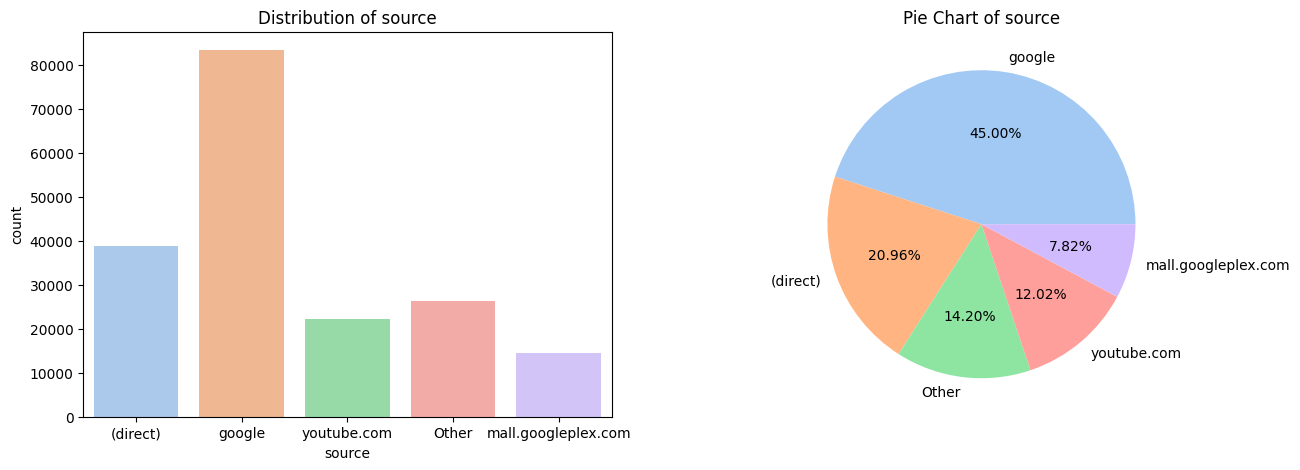

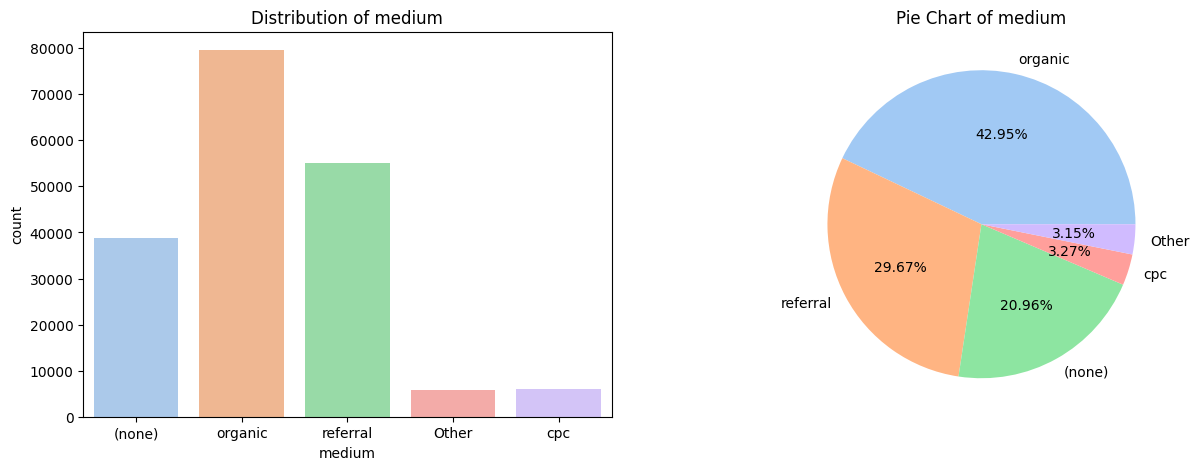

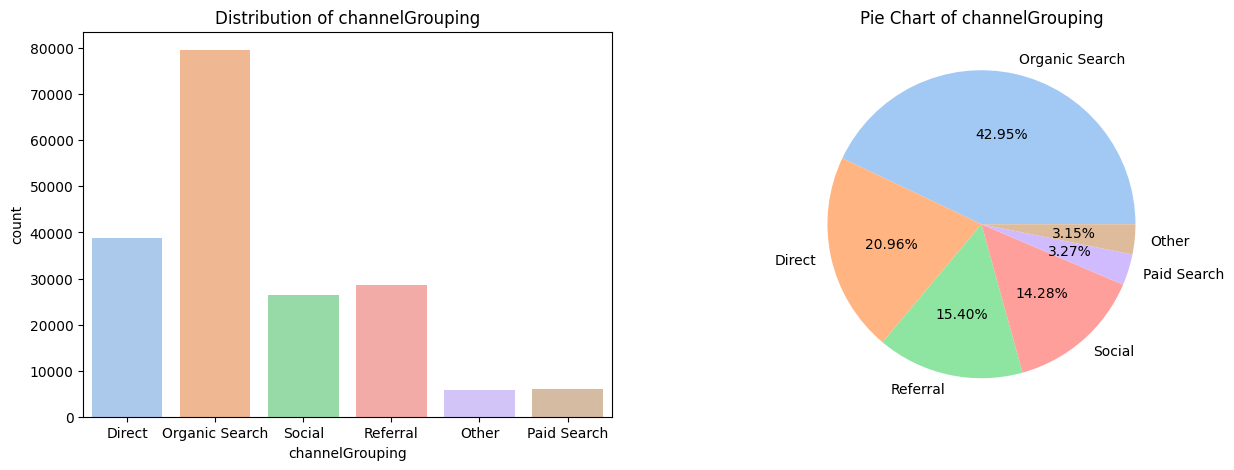

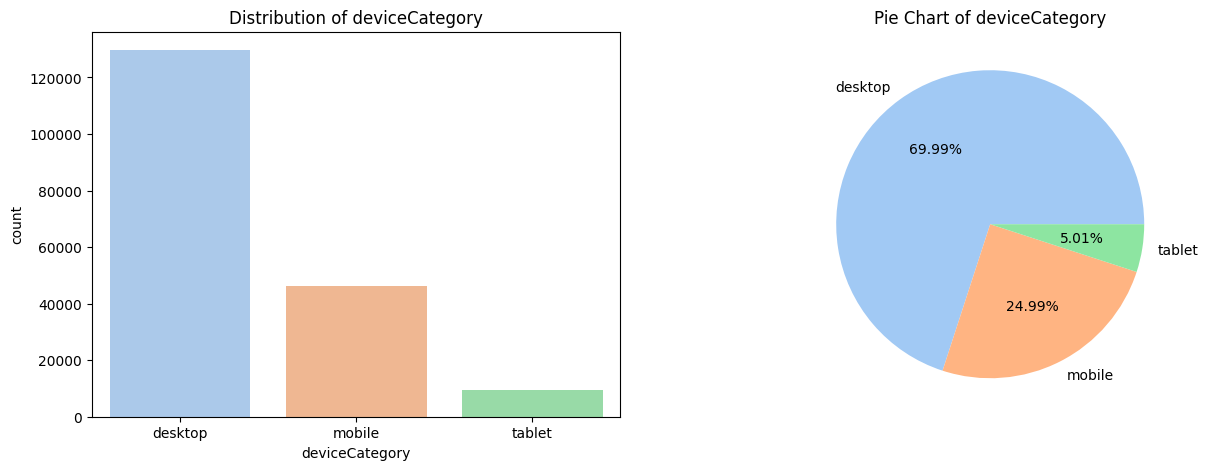

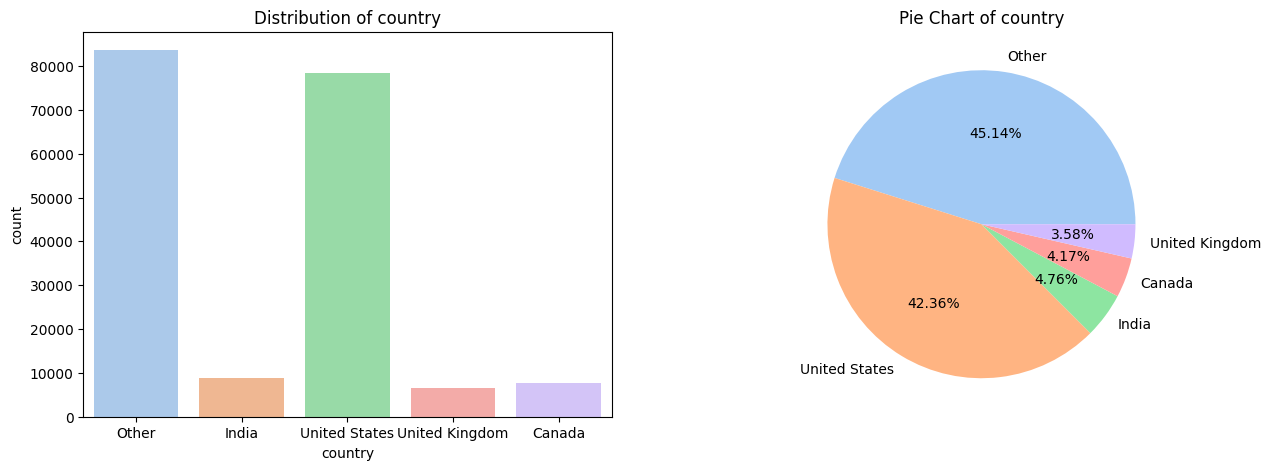

In [235]:
# Function to group small percentage values into "Other"
def group_other(series, threshold=0.03):
    total = len(series)
    value_counts = series.value_counts()
    small_categories = value_counts[value_counts / total < threshold].index
    return series.apply(lambda x: 'Other' if x in small_categories else x)

# Categorical column
for col in df_2.columns:
    if df_2[col].dtype == 'object':
        # Group into "Other"
        grouped_col = group_other(df_2[col])

        # Create canvas
        plt.figure(figsize=(15, 5))

        # Countplot
        plt.subplot(1, 2, 1)
        sns.countplot(x=grouped_col, palette='pastel', hue=grouped_col)
        plt.title(f'Distribution of {col}')

        # Pie Chart
        plt.subplot(1, 2, 2)
        counts = grouped_col.value_counts()
        pastel_colors = sns.color_palette('pastel')
        counts.plot.pie(autopct='%1.2f%%', colors=pastel_colors)
        plt.title(f'Pie Chart of {col}')
        plt.ylabel("")

        # Show
        plt.show()

**Insights**

From the visualizations, we can see that:  
- `source` : The top source is Google
- `medium` : The top medium is organic, means that most of the traffic came naturally (not through paid services)
- `channelGrouping`: The top channel is also Organic Search
- `deviceCategory` : Most visitors accessed the site using desktop
- `country`: The US is the second top visitors

**Checking unique values to see if the values are proper**

In [236]:
for col in df_2.columns:
    print(f'{col}: {df_2[col].unique()}')

will_buy_on_return_visit: [0 1]
latest_ecommerce_progress: [0 3 2 1 6 5 4]
bounces: [0 1]
time_on_site: [  54  167  184 ... 3529 9275 4424]
pageviews: [  5.   3.   1.   6.   7.   8.   9.  28.  13.  18.  24.   4.  10.  11.
  12.  36.  14.  17.  16.  20.  27.  23.  26. 132.   2.  15.  34.  19.
  25.  22.  21.  29.  33.  35.  37.  30.  32.  40.  47.  31.  48.  50.
  51.  42. 117.  65.  41. 219.  43.  55.  46.  98.  57.  39.  38.  54.
  44.  45.  52.  58.  49.  56.  61.  73.  53.  63.  60.  80.  68.  71.
  66.  64.  70.  67.  72.  82.  75.  78.  88.  83. 102. 110.  90. 104.
 121. 169. 142. 340. 431.  62.  59.  69.  81.  77.  85.  79.  76.  84.
  86. 100.  89. 103.  92. 111. 113.  94. 126. 147. 213. 158. 205. 333.
  nan 133. 148.  99.  74.  87. 185.  93. 114. 105. 146. 156. 341. 107.
 115. 119. 116. 108. 122. 124. 138. 118. 176. 130. 179. 171. 358. 128.
 125.  96. 109. 151. 183. 150. 191.  95. 123. 136. 154. 131. 165. 224.
 202. 270. 139. 400.  91. 106. 137. 134. 141. 343.  97. 101. 127. 14

Since in `medium` there are 2 unproper values `(none)` and `(not set)`, we will transform them into `Unknown`

In [237]:
df_2['medium'] = df_2['medium'].replace(['(none)', '(not set)'], 'Unknown')
df_2['medium'].value_counts()

medium
organic      79584
referral     54989
Unknown      38864
cpc           6059
affiliate     4880
cpm            935
Name: count, dtype: int64

**Answering Specific Objectives (Problem Breakdwown)**

1. Do bounces, time_on_site, and pageviews have a high enough influence to predict the will_buy_on_return_visit target?

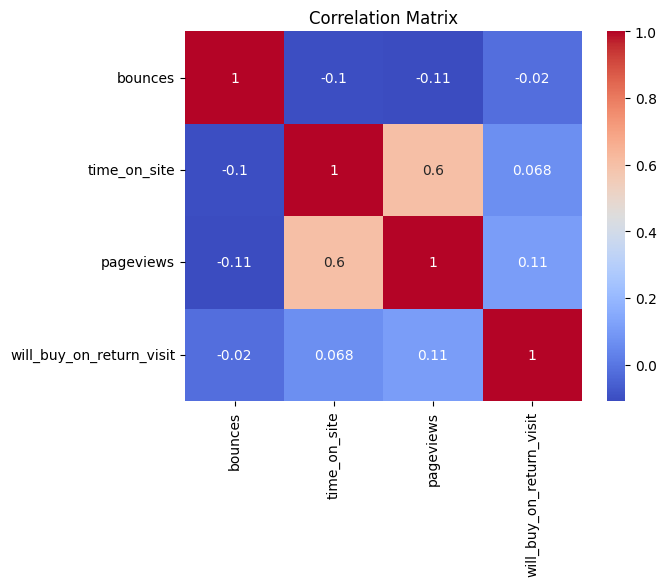

In [238]:
# Correlation matrix
corr_matrix = df_2[['bounces', 'time_on_site', 'pageviews', 'will_buy_on_return_visit']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

**Insights**

- Highest correlation: `pageviews` (positive)
- Weekest correlation: `bounces` (negative)

Since correlation only is not enough, we will also do a Chi-Squared Analysis.

**Chi2 for `bounces`**

In [239]:
# Create a contingency table
contingency_table = pd.crosstab(df_2['bounces'], df_2['will_buy_on_return_visit'])

# Chiq-squared Test
result = stats.chi2_contingency(contingency_table)
print("P-value:", result.pvalue)

if result.pvalue < 0.05:
    print("There is a significant relationship between bounces and will_buy_on_return_visit.")
else:
    print("No significant relationship between bounces and will_buy_on_return_visit.")

P-value: 1.2506744845685154e-17
There is a significant relationship between bounces and will_buy_on_return_visit.


The p-value is extremely small, which means that there is a statistically significant relationship between the variables bounces and will_buy_on_return_visit.

A bounce could be negatively correlated with a return visit purchase, meaning if users bounce, they are less likely to return and buy something.

**Chi2 for `pageviews`**

In [240]:
# Fill missing values with the median
check_pv = df_2.copy()
check_pv['pageviews'] = check_pv['pageviews'].fillna(check_pv['pageviews'].median())

# Split the data into two groups
group1 = check_pv[check_pv['will_buy_on_return_visit'] == 1]['pageviews']
group2 = check_pv[check_pv['will_buy_on_return_visit'] == 0]['pageviews']

# T-test
t_stat, p_val = ttest_ind(group1, group2)
print('T-Statistic:',t_stat)
print('P-value:',p_val)

if p_val < 0.05:
    print("There is a significant difference in pageviews between the two groups.")

T-Statistic: 47.00195520468825
P-value: 0.0
There is a significant difference in pageviews between the two groups.


The provided results of the t-test, with a t-statistic of 47.00195520468825 and a p-value of 0.0, indicate that there is a statistically significant difference in pageviews between the two groups being compared.

The t-statistic of 47.00 is extremely high, indicating a great difference in pageviews between the two groups (`will_buy_on_return_visit == 1` & `will_buy_on_return_visit == 0`).
The observed difference is statistically significant.

**Chi2 for `time_on_site`**

In [241]:
# T-test
group1_time = df_2[df_2['will_buy_on_return_visit'] == 1]['time_on_site']
group2_time = df_2[df_2['will_buy_on_return_visit'] == 0]['time_on_site']

t_stat_time, p_val_time = ttest_ind(group1_time, group2_time)
print('T-Statistic:',t_stat_time)
print('P-value:',p_val_time)

if p_val_time < 0.05:
    print("There is a significant difference in time_on_site between the two groups.")

T-Statistic: 29.516897840562407
P-value: 4.861915832243661e-191
There is a significant difference in time_on_site between the two groups.


The t-test results show a t-statistic of 29.52 and a p-value of 4.86e-191, indicating a statistically significant difference in time on site between the two groups. 
This means the groups differ in how long they stay on the site, and the difference is statistically significant.

**Conclusion**

All features (`bounces`, `pageviews`, `time_on_site`) have important influence on the target.

2. What type of device is most commonly used by users in the Canada region who are likely to make a purchase when revisiting the website?

    The most commont device by users in Canada who are likely to make a purchase is **desktop**.

In [242]:
df_2[(df_2['will_buy_on_return_visit'] == 1) & (df_2['country'] == 'Canada')].groupby('deviceCategory').agg({'deviceCategory': 'count'}).rename(columns={'deviceCategory': 'device_count'}).sort_values(by='device_count', ascending=False)

,device_count
deviceCategory,
desktop,165
mobile,11
tablet,1


# **vii. Modeling 1 - dataset_1**

## **vii.i. Modeling 1 - Feature Engineering**

> This section contains the data preparation process for model training, such as splitting the data into training and testing sets, data transformations (normalization, encoding, etc.), and other necessary processes.

### a. Cardinality Check

> We will not be doing cardinality check since it is not needed (all columns are numerical)

### b. Feature Extraction

> We will not be doing feature extraction since it is not needed

### c. Split X (features) dan y (target)

In [243]:
# Split between x and y
X_1 = df_1.drop(['will_buy_on_return_visit'], axis=1)
y_1 = df_1.will_buy_on_return_visit

### d. Split between Train and Test

In [244]:
# Splitting between train and test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=107)

print('train size:', X_train_1.shape)
print('test size:', X_test_1.shape)
print(X_train_1)

train size: (4323, 2)
test size: (1081, 2)
        bounces  time_on_site
237           0           219
117131        0          3155
2585          0          2043
276631        0          1790
5667          0           121
...         ...           ...
38791         0          5045
26761         0          2644
187173        0          2822
187520        0          5366
12557         0          1303

[4323 rows x 2 columns]


### e. Feature Transformation: Handling Outlier

Checking skewness of numerical columns

In [245]:
# Measurement of Central Tendency of time_on_site
print("Measurement of Central Tendency of time_on_site")
print(f"The average of time_on_site: {df_1['time_on_site'].mean():.2f}")
print(f"The median of time_on_site: {df_1['time_on_site'].median():.2f}")
print(f"The mode of time_on_site: {df_1['time_on_site'].mode()}")
print("\n")
# Measurement of Dispersion of time_on_site
print("Measurement of Dispersion of time_on_site")
variance = df_1['time_on_site'].var()
std = df_1['time_on_site'].std()
range = max(df_1['time_on_site']) - min(df_1['time_on_site'])
print(f'Variance of time_on_site: {variance:.2f}')
print(f'Standard Deviation of time_on_site: {std:.2f}')
print(f"Nilai minimum data time_on_site: {min(df_1['time_on_site'])}")
print(f"Nilai maksimum data time_on_site: {max(df_1['time_on_site'])}")
print(f"Nilai range data time_on_site: {range}")
print("\n")
# Measurement of Skewness and Kurtosis of time_on_site
print("Measurement of Skewness and Kurtosis of time_on_site")
print(f"Skewness: {df_1['time_on_site'].skew():.2f}")
print(f"Kurtosis: {df_1['time_on_site'].kurtosis():.2f}")

Measurement of Central Tendency of time_on_site
The average of time_on_site: 1671.58
The median of time_on_site: 1424.50
The mode of time_on_site: 0    0
Name: time_on_site, dtype: int64


Measurement of Dispersion of time_on_site
Variance of time_on_site: 1683680.81
Standard Deviation of time_on_site: 1297.57
Nilai minimum data time_on_site: 0
Nilai maksimum data time_on_site: 15047
Nilai range data time_on_site: 15047


Measurement of Skewness and Kurtosis of time_on_site
Skewness: 1.54
Kurtosis: 5.68


Based on the calculation results, it is concluded that:
- ```Skewness > 1```, means the data distribution is **highly skewed to the right**.
- ```Kurtosis > 0```, means the data distribution is **Leptokurtic**, indicating that the data has more outliers compared to a normal distribution.

Since the analysis shows that the data distribution is not normal, we will perform **Extreme Value Analysis (EVA)** using **Tukey's Rule**, based on the following formula:
```
up_bound = q3 + 1.5*iqr
low_bound = q1 - 1.5*iqr
```

In [246]:
# Menghitung kuartil data dan IQR
q1 = df_1['time_on_site'].quantile(0.25)
q3 = df_1['time_on_site'].quantile(0.75)
iqr = q3 -q1

# Menghitung up_bound dan low_bound data
up_bound = q3 + 1.5*iqr
low_bound = q1 - 1.5*iqr

# Print hasil perhitungan
print('Q1:',q1)
print('Q3:',q3)
print(f"Upper Boundary: {up_bound:.2f}")
print(f"Lower Boundary: {low_bound:.2f}")

# Print juga min dan max data
print("Max. value:", df_1['time_on_site'].max())
print("Min. value:", df_1['time_on_site'].min())

Q1: 677.0
Q3: 2382.25
Upper Boundary: 4940.12
Lower Boundary: -1880.88
Max. value: 15047
Min. value: 0


In [247]:
# Memisahkan data outlier dari data
outlier = df_1['time_on_site'][(df_1['time_on_site']<low_bound) | (df_1['time_on_site']>up_bound)]
no_outlier = df_1['time_on_site'][(df_1['time_on_site']>=low_bound) & (df_1['time_on_site']<=up_bound)]

In [248]:
percentage = len(outlier)/len(df_1['time_on_site'])*100
print(f"Percentage of outliers in the price data: {percentage:.2f}%")

Percentage of outliers in the price data: 1.92%


Although the outliers percentage is quite small, we will still handle the outliers, as for dataset_1 there are not many features and based on previous analysis, `time_on_site` has inlfuence on the target.

### f. Feature Transformation: Split between numerical and categorical columns

> We will not be doing this since it is not needed

### g. Feature Transformation: Handling Missing Values

In [249]:
# X_train check
X_train_1.isnull().sum()

bounces         0
time_on_site    0
dtype: int64

There is no null values.

### h. Feature Selection

> We will use all features

### i. Feature Transformation: Feature Scaling

Since the data is skewed, we will use MinMaxScaler.

Reference [https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/]


### j. Feature Transformation: Feature Encoding

> We will not be doing this since it is not needed

### k. Concat Final Data

In [250]:
X_train_final_1 = X_train_1
X_test_final_1 = X_test_1

## **vii.ii. Modeling 1 - Model Definition**

In [251]:
# Define the Pipeline
pipe = Pipeline([
    ('winsoriser', Winsorizer(capping_method='quantiles',
                              tail='right',
                              variables = ['time_on_site'],
                              fold=0.05,
                              missing_values='ignore')),
    ('scaler', MinMaxScaler()), 
    ('logreg', LogisticRegression(class_weight='balanced',random_state=42))
])


## **vii.iii. Modeling 1 - Model Training**

In [252]:
# Train the model
pipe.fit(X_train_final_1, y_train_1)

Pipeline(steps=[('winsoriser',
                 Winsorizer(capping_method='quantiles', fold=0.05,
                            missing_values='ignore',
                            variables=['time_on_site'])),
                ('scaler', MinMaxScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', random_state=42))])

## **vii.iv. Model 1 Evaluation**

In [253]:
# Predict Train and test

y_pred_train = pipe.predict(X_train_final_1)
y_pred_test = pipe.predict(X_test_final_1)

print(y_pred_train)

[1 0 0 ... 0 0 1]


In [254]:
# Classify roc_auc_score
def evaluate_roc_auc(roc_auc):
    if roc_auc > 0.9:
        return 'Good'
    elif 0.8 <= roc_auc <= 0.9:
        return 'Fair'
    elif 0.7 <= roc_auc < 0.8:
        return 'Decent'
    elif 0.6 <= roc_auc < 0.7:
        return 'Not Great'
    else:
        return 'Poor'

# Binarize the predictions
y_pred_proba = np.where(y_pred_test >= 0.5, 1, 0)  

# Calculate roc_auc_score
roc_auc = roc_auc_score(y_test_1, y_pred_proba)

# Print the roc_auc_score and evaluation
print(f"ROC AUC Score: {roc_auc:.2f}")
print(f"Evaluation: {evaluate_roc_auc(roc_auc)}")

ROC AUC Score: 0.66
Evaluation: Not Great


ROC AUC (0.56) means poor classification performance.
The model **needs improvement**.

F1 Score - Test Set   :  0.5864661654135338 

Classification Report : 
               precision    recall  f1-score   support

           0       0.80      0.61      0.69       699
           1       0.50      0.71      0.59       382

    accuracy                           0.64      1081
   macro avg       0.65      0.66      0.64      1081
weighted avg       0.69      0.64      0.65      1081
 



Confusion Matrix      : 


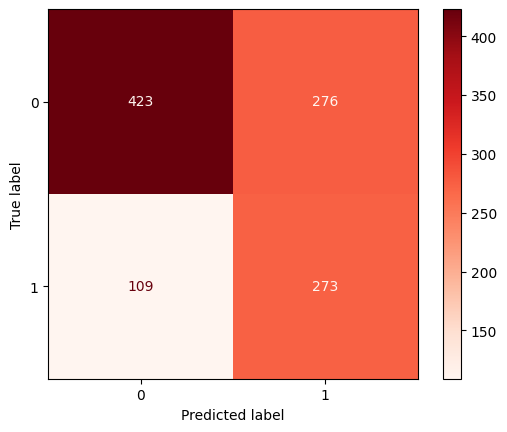

In [255]:
# Check Performance Model against Test-Set
print('F1 Score - Test Set   : ', f1_score(y_test_1, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test_1, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe, X_test_final_1, y_test_1, cmap='Reds'))

**Conclusion**

- The model performs well on class 0 but struggles on class 1 (low recall for class 1 (0.24), only 24% of actual class 1 labels are correctly classified).
- This imbalance in class performance means that the model is biased toward the majority class.
- Improvement: class weighting, smote, or algorithm tuning

# **viii. Modeling 2 - dataset_2**

## **viii.i. Modeling 2 - Feature Engineering**

### a. Feature Creation: Cardinality Check

In [256]:
# Checking the number of unique values in categorcial columns
for col in df_2.columns:
    if df_2[col].dtype == 'object':
      print(f'Number of categories in the variable {col}: {len(df_2[col].unique())}')

Number of categories in the variable source: 294
Number of categories in the variable medium: 6
Number of categories in the variable channelGrouping: 8
Number of categories in the variable deviceCategory: 3
Number of categories in the variable country: 218


From the data above, we can see that there is no column with a high cardinality.

### b. Feature Extraction

> We will not be doing feature extraction since it is not needed

### c. Split X (features) dan y (target)

In [257]:
# Split between x and y
X_2 = df_2.drop(['will_buy_on_return_visit'], axis=1)
y_2 = df_2.will_buy_on_return_visit

### d. Split between Train and Test

In [258]:
# Splitting between train and test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=107)

print('train size:', X_train_2.shape)
print('test size:', X_test_2.shape)
print(X_train_2)

train size: (148248, 9)
test size: (37063, 9)
        latest_ecommerce_progress  bounces  time_on_site  pageviews  \
525599                          0        0           203        3.0   
442189                          0        0           145        2.0   
238244                          2        0           251       11.0   
132556                          0        0           103        2.0   
477903                          2        0            83        4.0   
...                           ...      ...           ...        ...   
138680                          0        0             5        2.0   
331414                          3        0           720       44.0   
172446                          6        0           182       15.0   
242281                          0        0            63        5.0   
398480                          3        0           447        4.0   

                      source    medium channelGrouping deviceCategory  \
525599           youtube.com

### e. Feature Selection

We will select the features by **analyzing the correlation of the features to the target feature**.

In [259]:
# Manually splitting between categories for correlation only
num_col = ['time_on_site', 'pageviews']
cat_nominal_col = ['source', 'medium', 'channelGrouping', 'deviceCategory', 'country'] # nominal categorical column
encoded_col = ['latest_ecommerce_progress', 'bounces']

X_train_num = X_train_2[num_col]
X_test_num = X_test_2[num_col]

X_train_cat_nom = X_train_2[cat_nominal_col]
X_test_cat_nom = X_test_2[cat_nominal_col]

X_train_encoded = X_train_2[encoded_col]
X_test_encoded = X_test_2[encoded_col]

In [260]:
# Feature selection Numerical columns
p_values = []
interpretation = []
cols = []

for col in X_train_num.columns:
  clean_data = X_train_num[[col]].join(y_train_2).dropna()
  corr_coef, p_value = kendalltau(clean_data[col], clean_data[y_train_2.name])

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretation .append('Correlated')
  else :
    interpretation .append('Not correlated')

pd.DataFrame({'Column name':cols,
              'Result': interpretation})


,Column name,Result
0,time_on_site,Correlated
1,pageviews,Correlated


In [261]:
# Feature selection Numerical columns
p_values = []
interpretation = []
cols = []

for col in X_train_encoded.columns:
  clean_data = X_train_encoded[[col]].join(y_train_2).dropna()
  corr_coef, p_value = kendalltau(clean_data[col], clean_data[y_train_2.name])

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretation .append('Correlated')
  else :
    interpretation .append('Not correlated')

pd.DataFrame({'Column name':cols,
              'Result': interpretation})


,Column name,Result
0,latest_ecommerce_progress,Correlated
1,bounces,Correlated


In [262]:
# Feature selection Categorical columns
p_values = []
interpretation = []
cols = []

for col in X_train_cat_nom.columns:
  clean_data = X_train_cat_nom[[col]].join(y_train_2).dropna()
  corr_coef, p_value = kendalltau(clean_data[col], clean_data[y_train_2.name])

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretation.append('Correlated')
  else :
    interpretation.append('Not correlated')

pd.DataFrame({'Column name':cols,
              'Result': interpretation})

,Column name,Result
0,source,Correlated
1,medium,Not correlated
2,channelGrouping,Correlated
3,deviceCategory,Correlated
4,country,Correlated


The only column that is not correlated is `medium`, so we will drop it.

In [263]:
X_train_2.drop(columns=['medium'],inplace=True)
X_test_2.drop(columns=['medium'],inplace=True)

In [264]:
# medium is now dropped 
X_train_2

,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,channelGrouping,deviceCategory,country
525599,0,0,203,3.0,youtube.com,Social,desktop,Vietnam
442189,0,0,145,2.0,baidu,Organic Search,desktop,China
238244,2,0,251,11.0,google,Organic Search,desktop,United States
132556,0,0,103,2.0,youtube.com,Social,desktop,Ukraine
477903,2,0,83,4.0,youtube.com,Social,mobile,Thailand
...,...,...,...,...,...,...,...,...
138680,0,0,5,2.0,mall.googleplex.com,Referral,desktop,Canada
331414,3,0,720,44.0,mall.googleplex.com,Referral,desktop,United States
172446,6,0,182,15.0,(direct),Direct,mobile,United States
242281,0,0,63,5.0,analytics.google.com,Referral,desktop,United Kingdom


In [265]:
X_train_2

,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,channelGrouping,deviceCategory,country
525599,0,0,203,3.0,youtube.com,Social,desktop,Vietnam
442189,0,0,145,2.0,baidu,Organic Search,desktop,China
238244,2,0,251,11.0,google,Organic Search,desktop,United States
132556,0,0,103,2.0,youtube.com,Social,desktop,Ukraine
477903,2,0,83,4.0,youtube.com,Social,mobile,Thailand
...,...,...,...,...,...,...,...,...
138680,0,0,5,2.0,mall.googleplex.com,Referral,desktop,Canada
331414,3,0,720,44.0,mall.googleplex.com,Referral,desktop,United States
172446,6,0,182,15.0,(direct),Direct,mobile,United States
242281,0,0,63,5.0,analytics.google.com,Referral,desktop,United Kingdom


### f. Feature Transformation: Split between numerical and categorical columns

In [266]:
# Re-assign the categories of the columns
num_col = ['time_on_site', 'pageviews']
cat_nominal_col = ['source', 'channelGrouping', 'deviceCategory', 'country'] # nominal categorical column
encoded_col = ['latest_ecommerce_progress', 'bounces']

### g. Feature Transformation: Encoding

In [267]:
cat_nominal_col

['source', 'channelGrouping', 'deviceCategory', 'country']

Above are the columns needed to be encoded, every column is nominal, so we will only use **OneHotEncoder**

As for the ordinal ones, they have been encoded, so no encoding is needed for `latest_ecommerce_progress` and `bounces`.

We will add the encoding process in pipeline later.

### h. Feature Transformation: Handling Outlier

**Analysis for `skewness`**

In [268]:
# Check Skewness

# Numerical columns
num_cols = list(X_train_2.select_dtypes(exclude='object').columns)

# List of encoded columns to exclude
encoded_col = ['bounces', 'latest_ecommerce_progress']
num_cols = [col for col in num_cols if col not in encoded_col]

listItem= []

for col in num_cols:
  listItem.append([col, round(X_train_2[col].skew(),1), np.where(
    (round(X_train_2[col].skew(),1) <= 0.5) & (round(X_train_2[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])

skewness = pd.DataFrame(columns=['Column Name', 'Skewness Score', 'Distribution'], data= listItem)
skewness

,Column Name,Skewness Score,Distribution
0,time_on_site,3.5,skewed
1,pageviews,5.8,skewed


**Analysis for `time_on_site` outliers**

In [269]:
IQR_time = X_train_2['time_on_site'].quantile(0.75) - X_train_2['time_on_site'].quantile(0.25)
lower_boundary_time = X_train_2['time_on_site'].quantile(0.25) - (IQR_time * 1.5)
upper_boundary_time = X_train_2['time_on_site'].quantile(0.75) + (IQR_time * 1.5)

print(upper_boundary_time)
print(lower_boundary_time)

995.0
-493.0


In [270]:
# Memisahkan data outlier dari data
outlier_time = X_train_2['time_on_site'][(X_train_2['time_on_site']<lower_boundary_time) | (X_train_2['time_on_site']>upper_boundary_time)]
no_outlier_time = X_train_2['time_on_site'][(X_train_2['time_on_site']>=lower_boundary_time) & (X_train_2['time_on_site']<=upper_boundary_time)]

In [271]:
percentage_time = len(outlier_time)/len(X_train_2['time_on_site'])*100
print(f"Percentage of outliers in the price data: {percentage_time:.2f}%")

Percentage of outliers in the price data: 9.53%


**Analysis for `pageviews` outliers**

In [272]:
IQR_pv = X_train_2['pageviews'].quantile(0.75) - X_train_2['pageviews'].quantile(0.25)
lower_boundary_pv = X_train_2['pageviews'].quantile(0.25) - (IQR_pv * 1.5)
upper_boundary_pv = X_train_2['pageviews'].quantile(0.75) + (IQR_pv * 1.5)

print(upper_boundary_pv)
print(lower_boundary_pv)

23.0
-9.0


In [273]:
# Memisahkan data outlier dari data
outlier_pv = X_train_2['pageviews'][(X_train_2['pageviews']<lower_boundary_pv) | (X_train_2['pageviews']>upper_boundary_pv)]
no_outlier_pv = X_train_2['pageviews'][(X_train_2['pageviews']>=lower_boundary_pv) & (X_train_2['pageviews']<=upper_boundary_pv)]

In [274]:
percentage_pv = len(outlier_pv)/len(X_train_2['pageviews'])*100
print(f"Percentage of outliers in the price data: {percentage_pv:.2f}%")

Percentage of outliers in the price data: 6.61%


We will do outlier handling for both numerical columns, since the percentages are all above 5%.

We will use **Winsorizer** for this, and add it to pipeline.

### i. Feature Transformation: Handling Missing Values

In [275]:
# X_train check
X_train_2.isnull().sum()

latest_ecommerce_progress    0
bounces                      0
time_on_site                 0
pageviews                    9
source                       0
channelGrouping              0
deviceCategory               0
country                      0
dtype: int64

In [276]:
# Rows with any null values
null_rows = X_train_2[X_train_2[num_col].isnull().any(axis=1)]
print(null_rows)

        latest_ecommerce_progress  bounces  time_on_site  pageviews  \
526369                          0        0             1        NaN   
47893                           0        0             0        NaN   
118320                          0        0             0        NaN   
556448                          0        0            18        NaN   
46331                           0        0             0        NaN   
201661                          0        0             0        NaN   
41968                           0        0             0        NaN   
615349                          0        0             0        NaN   
40529                           0        0             0        NaN   

             source channelGrouping deviceCategory        country  
526369  youtube.com          Social         mobile    Philippines  
47893   youtube.com          Social        desktop      (not set)  
118320     (direct)          Direct        desktop  United States  
556448  youtube.c

Based on the null_rows, it seems that the null values in pageviews were due to page not loading properly, based on domain knowledge we will impute the null values with 0, assuming that the visitors didn't have the chance to properly see the content of the page.

We will use **SimpleImputer with a constant of 0** and add it to the pipeline.

### j. Feature Transformation: Feature Scaling

Since the data is skewed, we will use MinMaxScaler.

Reference [https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/]

## **viii.ii. Modeling 2 - Model Definition**

In [277]:
# Numerical pipeline
num_pipeline = Pipeline([
    ('winsoriser', Winsorizer(capping_method='quantiles',
                              tail='right',
                              fold=0.05,
                              missing_values='ignore')),
    ('imputer', SimpleImputer(strategy='constant', fill_value=1)),                          
    ('skewed_scaler', MinMaxScaler())
])

# Cat pipeline
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
    ('pipe_num', num_pipeline, num_col),
    ('pipe_cat', cat_pipeline, cat_nominal_col)
])

In [278]:
# The model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline), 
    ('smote', SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)), 
    ('model', LogisticRegression(class_weight='balanced',random_state=42)) 
])

## **viii.iii. Modeling 2 - Model Training**

In [279]:
%%time

model_pipeline.fit(X_train_2, y_train_2)

CPU times: user 1min 13s, sys: 6.55 s, total: 1min 19s
Wall time: 10.6 s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('winsoriser',
                                                                   Winsorizer(capping_method='quantiles',
                                                                              fold=0.05,
                                                                              missing_values='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('skewed_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time_on_site',
                                                   'pageviews']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['source', 'channelGrouping',
                                                   'deviceCategory',
                                                   'country'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=42))])

## **viii.iv. Model 2 Evaluation**

In [280]:
# Predict Train and test

y_pred_train_2 = model_pipeline.predict(X_train_2)
y_pred_test_2 = model_pipeline.predict(X_test_2)

print(y_pred_train_2)

[0 0 1 ... 0 0 0]


In [281]:
# Binarize the predictions
y_pred_proba_2 = np.where(y_pred_test_2 >= 0.5, 1, 0)  

# Calculate roc_auc_score
roc_auc_2 = roc_auc_score(y_test_2, y_pred_proba_2)

# Print the roc_auc_score and evaluation
print(f"ROC AUC Score: {roc_auc_2:.2f}")
print(f"Evaluation: {evaluate_roc_auc(roc_auc_2)}")

ROC AUC Score: 0.83
Evaluation: Fair


ROC AUC (0.83) means fair classification performance.
The model is **good enough, but still can be improved**.

F1 Score - Test Set   :  0.24122442189319582 

Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.75      0.85     35471
           1       0.14      0.91      0.24      1592

    accuracy                           0.75     37063
   macro avg       0.57      0.83      0.55     37063
weighted avg       0.96      0.75      0.83     37063
 

Confusion Matrix      : 


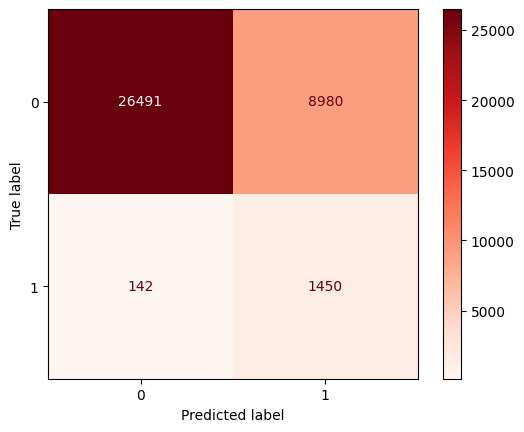

In [282]:
# Check Performance Model against Test-Set
print('F1 Score - Test Set   : ', f1_score(y_test_2, y_pred_test_2), '\n')
print('Classification Report : \n', classification_report(y_test_2, y_pred_test_2), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test_2, y_test_2, cmap='Reds'))

**Conclusion**

- The model has high recall but low precision for class 1 (minority class). It predicts many class 1 instances correctly but makes many incorrect predictions, leading to poor precision.
- Class 0 is very well, with high precision and a decent recall.
- The model is biased toward the majority class (class 0), which is normal with imbalanced data. So it's impacting the performance, especially for class 1.
- Improvement: class weighting, other smote techniques, cross validation, hyper parameter tunning, etc.

### **viii.iv.i Model 2 Hyperparameter Tuning**

**Hyperparameter Tuning**

We will do Hyperparameter Tuning for the model we made, to see the best hyperparameter settings.

The `grid_search_params` will refer to this [reference](https://www.geeksforgeeks.org/how-to-optimize-logistic-regression-performance/#:~:text=are%20implemented%20below%3A-,Step%201%3A%20Creating%20a%20Parameter%20Grid%20for%20Hyperparameter%20Tuning%20in%20Logistic%20Regression,-In%20the%20first).

In [283]:
%%time

# Define the parameter
grid_search_params = {
    'model__C': np.logspace(-4, 4, 5),
    'model__solver': ['lbfgs', 'liblinear'],
    'model__max_iter': [1000, 2500]
}

# GridSearchCV
clf_grid = GridSearchCV(model_pipeline, param_grid=grid_search_params, cv=3)

# Fit
clf_grid.fit(X_train_2, y_train_2)

# Get the best parameters and estimator
print(f"Best parameters: {clf_grid.best_params_}")
print(f"Best estimator: {clf_grid.best_estimator_}")

Best parameters: {'model__C': 0.0001, 'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('winsoriser',
                                                                   Winsorizer(capping_method='quantiles',
                                                                              fold=0.05,
                                                                              missing_values='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('skewed_scaler',
                                                          

In [284]:
# Predict

y_pred_train_tune = clf_grid.predict(X_train_2)
y_pred_test_tune= clf_grid.predict(X_test_2)

print(y_pred_train_tune)

[0 0 0 ... 0 0 0]


In [288]:
# Binarize the predictions
y_pred_proba_tune = np.where(y_pred_test_tune >= 0.5, 1, 0)  

# Calculate roc_auc_score
roc_auc_tune = roc_auc_score(y_test_2, y_pred_proba_tune)

# Print evaluation
print(f"ROC AUC Score: {roc_auc_tune:.2f}")
print(f"Evaluation: {evaluate_roc_auc(roc_auc_tune)}")

ROC AUC Score: 0.80
Evaluation: Fair


ROC AUC (0.83) means fair classification performance.
The model is **good enough, but still can be improved**. 
However, it was slighly lower than when not doing tuning.

F1 Score - Test Set   :  0.24689048910502198 

Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.78      0.87     35471
           1       0.15      0.83      0.25      1592

    accuracy                           0.78     37063
   macro avg       0.57      0.80      0.56     37063
weighted avg       0.95      0.78      0.85     37063
 

Confusion Matrix      : 


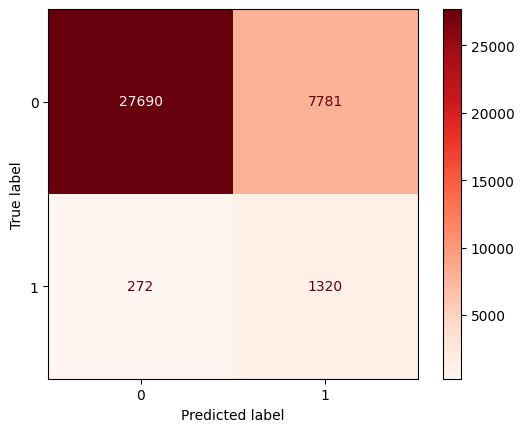

In [289]:
# Check Performance Model against Test-Set
print('F1 Score - Test Set   : ', f1_score(y_test_2, y_pred_test_tune), '\n')
print('Classification Report : \n', classification_report(y_test_2, y_pred_test_tune), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(clf_grid, X_test_2, y_test_2, cmap='Reds'))

The overall result of the confusion matrix is also slightly worse than without doing tuning.

# **ix. Model Saving**

Since **the result without hyperparameter tuning is better**, we will save and use the one without it **for model inference**.

In [290]:
# Save model
with open('model_pipeline.pkl','wb') as file_1: #wb = write binary
    pickle.dump(model_pipeline,file_1)

with open('preprocessing_pipeline.pkl','wb') as file_2: #wb = write binary
    pickle.dump(preprocessing_pipeline,file_2)

with open('cat_pipeline.pkl','wb') as file_3: #wb = write binary
    pickle.dump(cat_pipeline,file_3)

with open('num_pipeline.pkl','wb') as file_4: #wb = write binary
    pickle.dump(num_pipeline,file_4)

# Save cols
with open('num_col.txt','w') as file_5: #w = write
    json.dump(num_col,file_5)

with open('cat_nominal_col.txt','w') as file_6: #w = write
    json.dump(cat_nominal_col,file_6)

# **x. Model Inference**

> File: P1G5_yocia_meiko_inf.ipynb

# **xi. Conclusion**

Final conclusion of this project is that:

- The model has a way better performance using more features in `dataset_2`.

- We can say the final model is good-fit, looking at the ROC AUC score of 0.83, this is considered as **Fair**. 

- ROC AUC is a good metric since it shows the overall performance of the model, however, we can specifically focus on recall if we want to tackle a speicfic goal.

- Since we want to predict if a visitor will make a purchase in the next visit or not, we will focus on the recall, as missing potential buyers will be a disadvantage more. (In marketing, we want to get as many potential buyers as possible, even if some turn out not purchasing).

- After doing Hyperparamter Tuning, the overall result was lower than without doing it, with ROC AUC of 0.80. Hence, the model without tuning is used for model inference.

Further Prediction Recommendation:

- Handle the imbalance data better by tuning SMOTE, since it's result seemed to be really impacted by the data imbalance.

Further Business Recommendation:

- Focus on visitors from Google

- Enhance SEO by writing blogs that are relevant to the target visitors, this can increase Organic Search if we target it correctly.

- Enhance the UI/UX of desktop view, since desktop is the most common device used by our visitors.